<a href="https://colab.research.google.com/github/umair-hassan2/ViT-Insight/blob/master/ViT_attention_Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [265]:
from PIL import Image
import requests
from IPython.display import display

from transformers import CLIPProcessor, CLIPModel, CLIPVisionModel

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import io

In [242]:
MODEL_ID = "openai/clip-vit-base-patch32"

In [243]:
processor = CLIPProcessor.from_pretrained(MODEL_ID)

In [244]:
model = CLIPModel.from_pretrained(MODEL_ID)

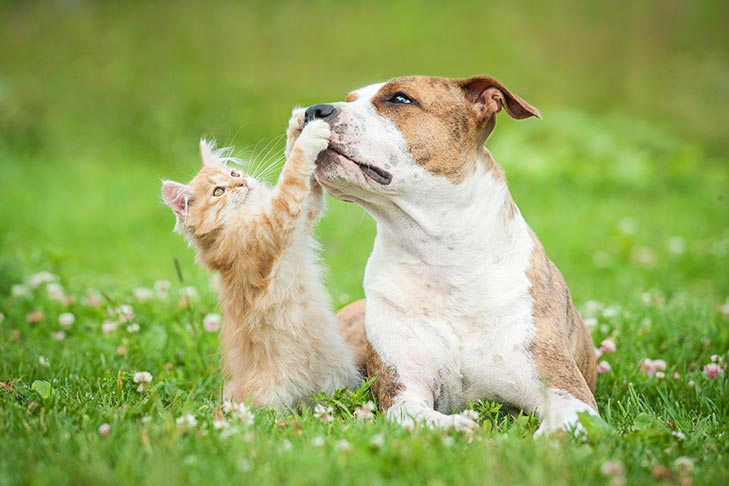

In [272]:
url = "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg"
image = Image.open(requests.get(url, stream=True).raw)
display(image)

In [273]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

In [274]:
with torch.no_grad():
  outputs = model(**inputs, output_attentions=True) # returns self attentions weights for both text and vision encoders

In [275]:
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities
probs

tensor([[0.4281, 0.5719]])

In [276]:
attentions = outputs.vision_model_output.attentions

In [277]:
attn_last = attentions[-1]
attn_avg = attn_last.mean(dim=1)
cls_token = attn_avg[:, 0, 1:]
cls_token.shape

torch.Size([1, 49])

In [278]:
batch_size, num_patches = cls_token.shape
h = w = int(num_patches ** 0.5)
cls_attn_grid = cls_token.reshape(batch_size, 1, h, w)

In [279]:
image_size = inputs.pixel_values.shape[-2:]
heatmap = F.interpolate(cls_attn_grid, size=image_size, mode="bilinear")

In [280]:
heatmap = heatmap[0,0].cpu().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

In [281]:
img = inputs.pixel_values[0].permute(1, 2, 0).cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

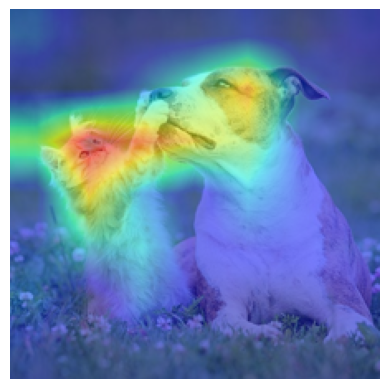

In [282]:
plt.imshow(img)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()

In [283]:
# Attention rollout across layers
cls_attn_per_layer = []
for l, attn in enumerate(attentions):
  attn_avg = attn.mean(dim=1)
  cls_attn = attn_avg[:, 0, 1:]
  cls_attn_per_layer.append(cls_attn)

In [284]:
num_patches = int(cls_attn_per_layer[0].shape[1] ** 0.5)
num_batches = int(cls_attn_per_layer[0].shape[0])
maps_per_layer = [attn.reshape(num_batches,1,  num_patches, num_patches) for attn in cls_attn_per_layer]
maps_per_layer[0].shape

torch.Size([1, 1, 7, 7])

In [285]:
image_size = inputs.pixel_values.shape[-2:]
heatmap_per_layer = [F.interpolate(attn, size=image_size, mode="bilinear") for attn in maps_per_layer]

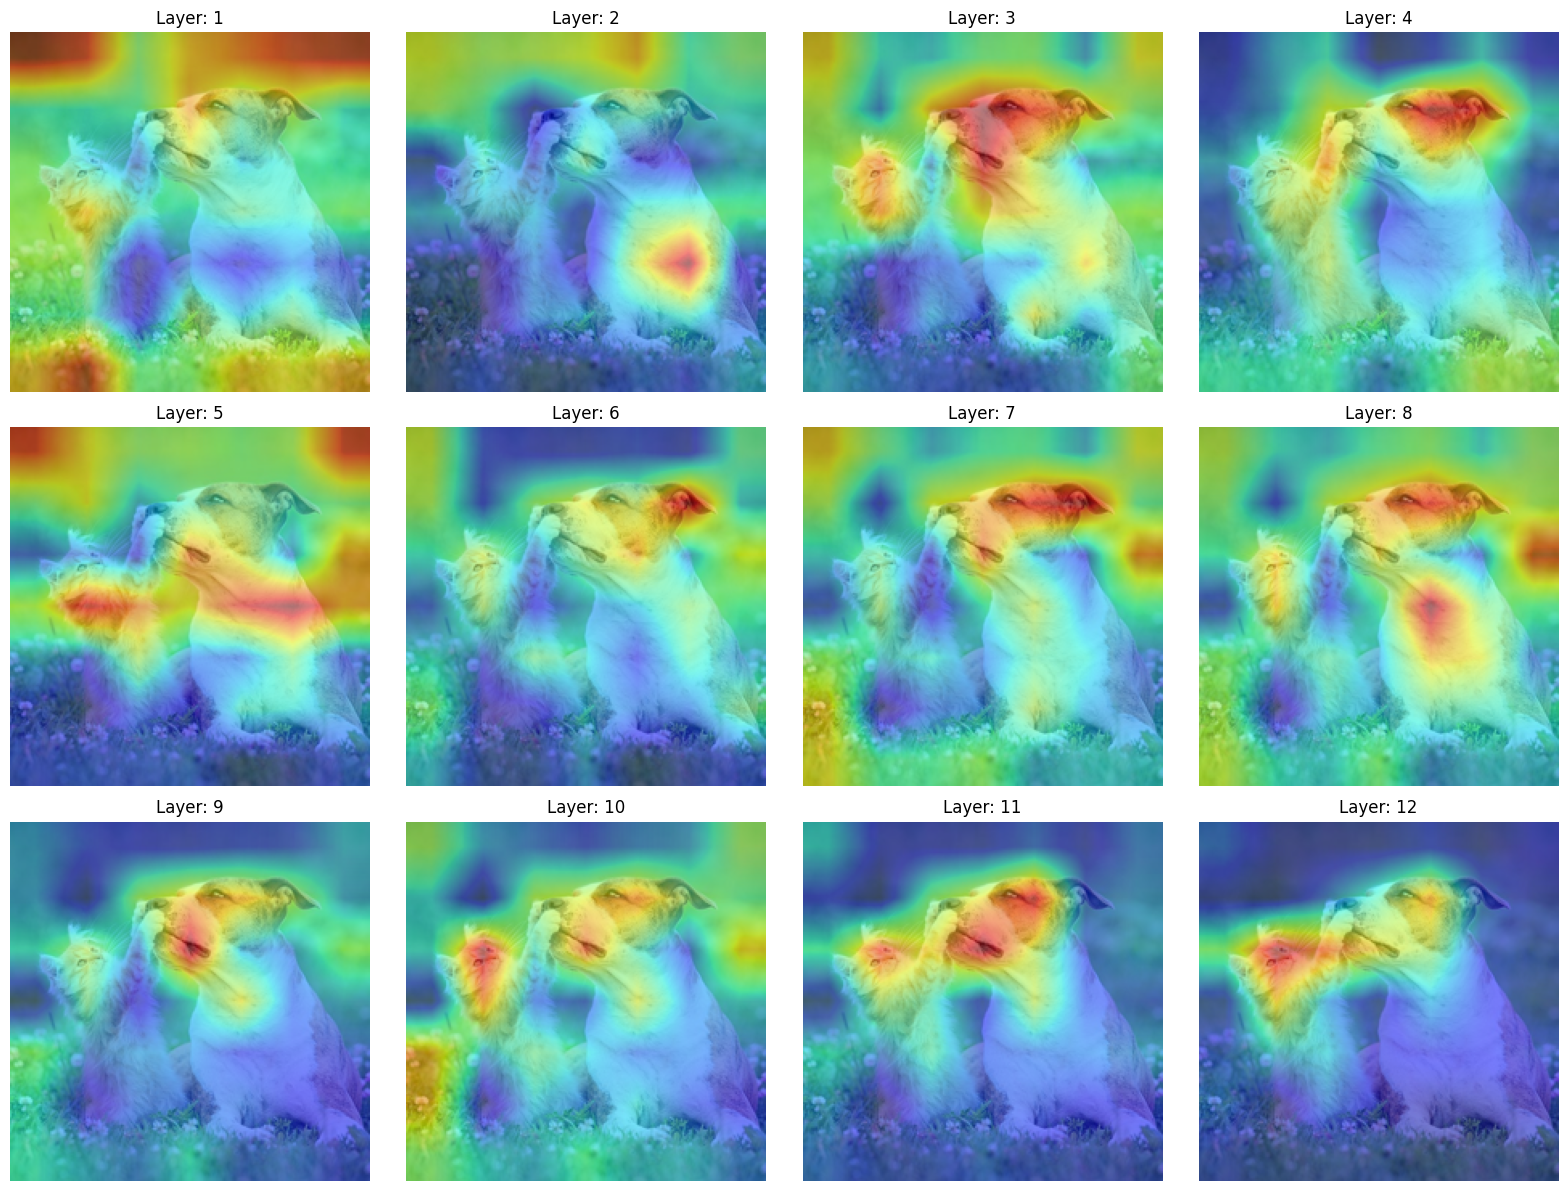

In [286]:
num_layers = len(heatmap_per_layer)
cols = 4
rows = int(np.ceil(num_layers / cols))
plt.figure(figsize=(4*cols, 4*rows))

for l, heatmap in enumerate(heatmap_per_layer):
  plt.subplot(rows, cols, l + 1)

  # normalize heatmap for better comparison
  hm = heatmap[0, 0].cpu().numpy()
  hm = (hm - hm.min()) / (hm.max() - hm.min() + 1e-8)

  plt.imshow(img)
  plt.imshow(hm, cmap="jet", alpha=0.5)
  plt.axis("off")
  plt.title(f"Layer: {l + 1}")

plt.tight_layout()
plt.show()

In [287]:
def attention_rollout(attentions, start_layer=0):
  device = attentions[0].device
  rollout = torch.eye(attentions[0].size(-1)).to(device)
  for l, attn in enumerate(attentions[start_layer:]):
    attn_avg = attn.mean(dim=1)
    attn_avg = attn_avg / attn_avg.sum(dim=-1, keepdim=True) # normalize values between 0 and 1
    rollout = rollout @ attn_avg
  return rollout

In [288]:
rollout = attention_rollout(attentions)
# in rollout R[i, j] represents how token i impacts token j after L layers of attention
# We want to know the impact or rollout of CLS token
cls_rollout = rollout[:, 0, 1:]

In [289]:
num_patches = int(cls_rollout.size(-1)**0.5)
rollout_map = cls_rollout.reshape(-1, num_patches, num_patches)
rollout_map = F.interpolate(rollout_map.unsqueeze(0), size=image_size, mode="bilinear")[0, 0].cpu().numpy()

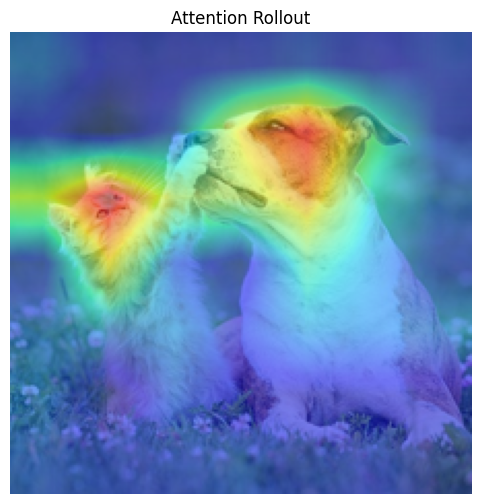

In [290]:
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.imshow(rollout_map, cmap="jet", alpha=0.5)
plt.axis("off")
plt.title("Attention Rollout")
plt.show()

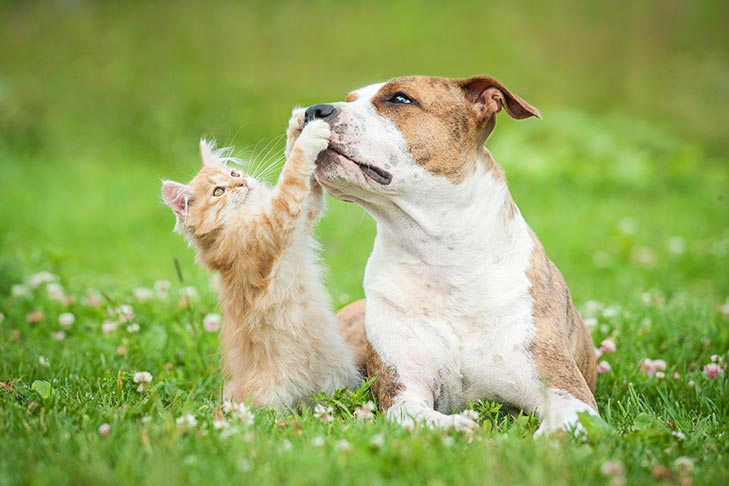

In [291]:
display(image)